In [2]:
!which python
%load_ext autoreload
%autoreload 2
%matplotlib inline

/home/users/ujjwal.upadhyay/miniconda3/envs/train/bin/python


In [10]:
from qtrain.utils.defaults import *

import qtrain

# import munch, json
import torch
import monai
import torch.nn as nn
import segmentation_models_pytorch as smp

from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl

Unable to find logging config yaml. Configuring fallback values


In [8]:
with open("template.json", "r") as f:
    args = munch.munchify(json.load(f))

In [11]:
df = pd.read_json(
    "/cache/datanas1/qer/all_studies_safetensor/jsons/e2e_train+val_d62K_26_07_23.json"
)
df

,series,filepath,annotpath,acute,chronic,normal,set,status,labels,crop,sample_wts,annotation
0,1.2.840.113619.2.25.1.1761985627.1415345710.730,/cache/datanas1/qer/all_studies_safetensor/res...,None,0,0,1,C,train,{'Infarct': []},"[[0, 28], [10, 472], [92, 444]]",0.850527,0
1,1.2.840.113619.2.81.290.1.3343.2.20131012.230725,/cache/datanas1/qer/all_studies_safetensor/res...,None,0,0,1,C,train,{'Infarct': []},"[[0, 24], [54, 472], [96, 426]]",0.850527,0
2,1.2.840.113619.2.55.3.2831165733.49.1418099688...,/cache/datanas1/qer/all_studies_safetensor/res...,None,0,0,1,C,train,{'Infarct': []},"[[0, 32], [66, 490], [86, 420]]",0.850527,0
3,1.2.840.113619.2.278.3.2831165729.116.14434241...,/cache/datanas1/qer/all_studies_safetensor/res...,None,0,0,1,C,train,{'Infarct': []},"[[0, 30], [52, 476], [116, 434]]",0.850527,0
4,1.2.840.113619.2.81.290.1.14454.3.20180922.230659,/cache/datanas1/qer/all_studies_safetensor/res...,None,0,0,1,C,train,{'Infarct': []},"[[0, 22], [0, 382], [80, 426]]",0.850527,0
...,...,...,...,...,...,...,...,...,...,...,...,...
62216,1.2.840.113619.2.278.3.2831165752.313.13907914...,/cache/datanas1/qer/all_studies_safetensor/seg...,/cache/datanas1/qer/all_studies_safetensor/seg...,-100,-100,0,A,valid,{'Infarct': [1]},"[[45, 511], [47, 454]]",9.627768,0
62217,1.2.840.113619.2.278.3.2831165736.474.13628210...,/cache/datanas1/qer/all_studies_safetensor/seg...,/cache/datanas1/qer/all_studies_safetensor/seg...,-100,-100,0,A,valid,{'Infarct': [1]},"[[0, 24], [82, 478], [92, 400]]",9.627768,1
62218,1.2.840.113619.2.278.3.2831165736.7.1343222201...,/cache/datanas1/qer/all_studies_safetensor/seg...,/cache/datanas1/qer/all_studies_safetensor/seg...,-100,-100,0,A,valid,{'Infarct': [1]},"[[0, 22], [52, 462], [98, 406]]",9.627768,1
62219,1.2.840.113619.2.278.3.2831165736.6.1368930853.83,/cache/datanas1/qer/all_studies_safetensor/seg...,/cache/datanas1/qer/all_studies_safetensor/seg...,-100,-100,0,A,valid,{'Infarct': [1]},"[[57, 509], [23, 500]]",9.627768,0


In [56]:
len(df.loc[df.set == "A"])

2348

In [69]:
df_new.groupby("set").status.value_counts()

set  status
A    train     1882
     valid      466
C    train     1501
     valid      701
Name: count, dtype: int64

In [70]:
df_new = pd.concat(
    [
        df.loc[df.set == "A"].reset_index(drop=True),
        df.loc[(df.set == "C") & (df.status == "train")]
        .reset_index(drop=True)
        .loc[:1500, :],
        df.loc[(df.set == "C") & (df.status == "valid")]
        .reset_index(drop=True)
        .loc[:500, :],
    ]
)
df_new = df_new.reset_index(drop=True)
df_new

,series,filepath,annotpath,acute,chronic,normal,set,status,labels,crop,sample_wts,annotation
0,1.2.840.113619.2.55.3.2831165736.118.137428500...,/cache/datanas1/qer/all_studies_safetensor/res...,/cache/datanas1/qer/all_studies_safetensor/seg...,0,1,0,A,train,{'Infarct': [1]},"[[0, 26], [30, 476], [86, 424]]",16.871806,1
1,1.2.840.113619.2.55.3.2831165742.271.145164062...,/cache/datanas1/qer/all_studies_safetensor/res...,/cache/datanas1/qer/all_studies_safetensor/seg...,-100,-100,0,A,train,{'Infarct': [1]},"[[0, 29], [12, 466], [84, 428]]",16.871806,1
2,1.2.840.113619.2.55.3.2831165736.692.138792935...,/cache/datanas1/qer/all_studies_safetensor/res...,/cache/datanas1/qer/all_studies_safetensor/seg...,0,1,0,A,train,{'Infarct': [1]},"[[0, 31], [20, 502], [60, 422]]",16.871806,1
3,1.3.12.2.1107.5.1.4.40318.5.0.6919493219251052,/cache/datanas1/qer/all_studies_safetensor/res...,/cache/datanas1/qer/all_studies_safetensor/seg...,1,0,0,A,train,{'Infarct': [1]},"[[0, 28], [0, 502], [62, 454]]",16.871806,1
4,1.2.840.113619.2.278.3.2831165735.336.13299563...,/cache/datanas1/qer/all_studies_safetensor/res...,/cache/datanas1/qer/all_studies_safetensor/seg...,0,1,0,A,train,{'Infarct': [1]},"[[0, 31], [26, 456], [98, 426]]",16.871806,1
...,...,...,...,...,...,...,...,...,...,...,...,...
4345,1.2.840.113619.2.55.3.2831165748.482.143262621...,/cache/datanas1/qer/all_studies_safetensor/res...,None,0,0,1,C,valid,{'Infarct': []},"[[0, 27], [46, 456], [92, 400]]",0.485347,0
4346,1.2.840.113619.2.55.3.2831165748.958.143260956...,/cache/datanas1/qer/all_studies_safetensor/res...,None,0,0,1,C,valid,{'Infarct': []},"[[0, 35], [16, 482], [62, 438]]",0.485347,0
4347,1.2.840.113619.2.81.290.8017.40295.2.20150529....,/cache/datanas1/qer/all_studies_safetensor/res...,None,0,0,1,C,valid,{'Infarct': []},"[[0, 19], [28, 480], [66, 414]]",0.485347,0
4348,1.3.12.2.1107.5.1.4.60438.30000015052902543312...,/cache/datanas1/qer/all_studies_safetensor/res...,None,0,0,1,C,valid,{'Infarct': []},"[[0, 32], [22, 486], [100, 448]]",0.485347,0


In [71]:
df_new.to_json(
    "/cache/datanas1/qer/all_studies_safetensor/jsons/e2e_train+val_setA_C.json"
)

# df.loc[df.set=="A"].reset_index(drop=True).to_json(
#     "/cache/datanas1/qer/all_studies_safetensor/jsons/e2e_train+val_setA.json"
# )

In [6]:
df.groupby("set").annotation.value_counts()

set  annotation
A    1              1991
     0               357
B    1             13296
C    0             46577
Name: count, dtype: int64

In [16]:
args.datapath = (
    "/cache/datanas1/qer/all_studies_safetensor/jsons/e2e_train+val_setA_C.json"
)
args.dataset_class_60k = True
args.save_checkpoints = "/home/users/ujjwal.upadhyay/projects/qtrain/logs"
# args.sampler = True
args.sampler = None
args.n_samples = 1000
args.gpu = [0, 1]
args.precision = 32
args.strategy = "ddp"
args.crop = True
args.patience = 100
args.ignore_index = -100

args.n_slices = 64
args.valid_n_slices = args.n_slices
args.img_size = 224


args.max_epoch = 200
args.batch_size = 2
args.val_batch_size = 2
args.num_workers = 8
args.prefetch = 2
args.accumulate_grad_batches = 8
args.gradient_clip_val = 0.5
args.gradient_clip_algorithm = "norm"

args.only_annotated = False
args.augmentation = True

args.windowing = "old"

# args.loss_contrib = munch.munchify({
#     "seg/focal": 5,
#     "seg/mcc": 3,
#     "seg/dice": 3,
#     "cls/bce": 2
# })


# import qtrain.losses.dice_loss
# args.losses = munch.munchify({
#     "seg/focal": smp.losses.FocalLoss(mode="binary"),
#     "seg/dice": qtrain.losses.dice_loss.GDiceLossV2(),
#     "seg/mcc": smp.losses.MCCLoss(),
#     "cls/bce": nn.CrossEntropyLoss(weight=torch.FloatTensor([1.,1.]))
# })

args.seg_loss_wts = munch.munchify({"focal": 1})

args.cls_loss_wts = munch.munchify(
    {
        "ce": 3,
    }
)

args.slc_loss_wts = munch.munchify(
    {
        "bce": 1,
    }
)


# assert len(args.loss_contrib) == len(args.losses)

# args.metrics = munch.munchify({
#     "seg/dice": M.DiceMetric(include_background=True, reduction="mean"),
#     "seg/mse": M.MSEMetric()
# })


# args.optimizer = torch.optim.Adam
# args.optimizer_params = munch.munchify({
#     'lr': 5e-3,
#     'betas':(0.9, 0.999),
#     'eps': 1e-08,
#     'weight_decay': 0
# })


args.optimizer = torch.optim.SGD
args.optimizer_params = munch.munchify({"lr": 5e-3, "momentum": 0.9})

# args.optimizer = torch.optim.Adam
# args.optimizer_params = munch.munchify({
#     'lr': 5e-2,
#     'betas':(0.9, 0.999),
#     'eps': 1e-08,
#     'weight_decay': 0.9
# })

# args.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau
# args.scheduler_params = munch.munchify({
#     'mode':'min',
#     'factor': 0.1,
#     'patience': 10,
#     'verbose': True,
#     'min_lr': 1e-6
# })

# args.scheduler = torch.optim.lr_scheduler.MultiStepLR
# args.scheduler_params = munch.munchify({
#     'milestones': [50, 100, 150, 200],
#     'gamma': 0.2
# })

args.scheduler = torch.optim.lr_scheduler.OneCycleLR
args.scheduler_params = munch.munchify(
    {
        "max_lr": 1e-2,
        "total_steps": None,
        "pct_start": 0.3,
        "anneal_strategy": "cos",
        "cycle_momentum": True,
        "base_momentum": 0.85,
        "max_momentum": 0.95,
        "div_factor": 25.0,
        "final_div_factor": 10000.0,
        "three_phase": False,
        "last_epoch": -1,
        "verbose": False,
    }
)

# args.scheduler = torch.optim.lr_scheduler.CyclicLR
# args.scheduler_params = munch.munchify({
#     "base_lr": 5e-4,
#     "max_lr": 5e-2
# })


# args.sampler = None

# args.dataset_type = "3D"
# args.dataset_class = qtrain.dataset.infarct.InfarctDataset3D
# args.dataset_module = qtrain.dataset.infarct.InfarctDataModule

# args.model = qtrain.models.fresnet.model.FusionResnet
# args.model_params_star_pass = True
# args.model_params = munch.munchify({
#     "resnet": "seresnet50",
#     "attn_mode":"softminmax",
#     "img_size": (args.n_slices, args.img_size, args.img_size)
# })

# args.model = "se_multitasker"
args.model = "multitask_qer"
args.encoder_name = "se_resnet50"

# import qtrain.models.unet.unet2dseqattn
# args.model = qtrain.models.unet.unet2dseqattn.UnetSeqAttn
# args.model_params_star_pass = False
args.model_params = munch.munchify(
    {
        "encoder_name": args.encoder_name,
        "in_channels": 3,
        "depth": 4,
        "output_stride": 16,
        "decoder_channels": (128, 64, 32, 16),
        "use_batchnorm": True,
        "attention_type": "scse",
        "n_segmaps": 2,
        "seg_activation": None,
        "kernel_size": 5,
        "cls_nclasses": 2,
        "cls_pooling": "avg",
        "cls_dropout": 0.3,
        "cls_ac_nclasses": 2,
        "cls_ac_pooling": "avg",
        "cls_ac_dropout": 0.3,
        "cls_normal_nclasses": 2,
        "cls_normal_pooling": "avg",
        "cls_normal_dropout": 0.3,
        "n_slices": args.n_slices,
    }
)


# Unet3d
# args.model_params = munch.munchify({
#     "spatial_dims": 3,
#     "in_channels": 3,
#     "out_channels": 1,
#     "channels": (8, 16, 32, 64),
#     "strides": (2, 2, 2),
#     "kernel_size": 5,
#     "up_kernel_size": 5,
#     "num_res_units": 15,
#     "act": 'PRELU',
#     "norm": 'INSTANCE',
#     "dropout": 0.2,
#     "bias": True,
#     "adn_ordering": 'NDA'
# })

In [17]:
args.fast_batch_size = 4
# args.overfit_batches=0.01
args.fast_dev_run = False

with open("../configs/multitasker_seresnet50_02_08_23.yaml", "w") as f:
    yaml.dump(args, f)

In [146]:
with open("../configs/multitasker_512_seresnet50_02_08_23.yaml", "r") as f:
    args_yaml = munch.munchify(yaml.load(f, Loader=yaml.Loader))

In [148]:
args_yaml.encoder_name

'resnet34'

In [30]:
import torch, torchmetrics as tm

In [32]:
miou = tm.classification.JaccardIndex(task="binary", num_classes=2, ignore_index=-100)

In [37]:
miou(
    torch.ones((3, 224, 224)),
    torch.vstack([torch.ones((1, 224, 224)) * -100, torch.ones((2, 224, 224)) * -100]),
)

tensor(nan)

In [41]:
gt = torch.vstack(
    [
        torch.ones((1, 224, 224)) * -100,
        torch.zeros((2, 224, 224)),
        torch.ones((2, 224, 224)),
    ]
)

In [44]:
gt[gt.sum(axis=(1, 2)) <= 0] = -100

In [49]:
gt[0]

tensor([[-100., -100., -100.,  ..., -100., -100., -100.],
        [-100., -100., -100.,  ..., -100., -100., -100.],
        [-100., -100., -100.,  ..., -100., -100., -100.],
        ...,
        [-100., -100., -100.,  ..., -100., -100., -100.],
        [-100., -100., -100.,  ..., -100., -100., -100.],
        [-100., -100., -100.,  ..., -100., -100., -100.]])

In [ ]:
gt[gt.sum(axis=(2, 3)) <= 0] = self.ignore_index

In [46]:
gt = torch.tensor([-100, -100])
pred = torch.tensor([0.5, 0.5])
gt_ = gt[gt > 0]
pred[gt > 0]

tensor([])

In [52]:
torch.mean(
    torch.nn.BCEWithLogitsLoss(reduction="none")(pred.double(), gt.double()) * (gt > 0)
)

tensor(0., dtype=torch.float64)

In [59]:
torch.tensor([[[0.3, 0.2], [0.5, 0.3]]]), torch.tensor([[[-100, -100]]])

(torch.Size([1, 2, 2]), torch.Size([1, 1, 2]))

In [63]:
gt = torch.ones(120, 224, 224) * -100

In [95]:
gt = torch.vstack([torch.ones(60, 224, 224) * -100, torch.ones(60, 224, 224) * -100])

In [97]:
a = smp.losses.FocalLoss(mode="multiclass", ignore_index=-100, reduction="none")(
    torch.randn(120, 2, 224, 224), torch.ones_like(gt)
)
a

tensor([0.2328, 0.5071, 0.3637,  ..., 0.4482, 0.1661, 1.0009])

In [105]:
gt.flatten().shape

torch.Size([6021120])

In [106]:
torch.mean(a * (gt.flatten() >= 0))

tensor(0.)

In [107]:
torch.all(gt == -100)

tensor(True)

In [110]:
import torchmetrics as tm

miou = tm.JaccardIndex(task="binary", num_classes=2, ignore_index=-100, average="none")

In [114]:
torch.nn.functional.softmax(torch.randn(120, 2, 224, 224)).argmax(1).shape

/tmp/ipykernel_3421264/504142527.py:1: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



torch.Size([120, 224, 224])

In [116]:
miou(
    torch.nn.functional.softmax(torch.randn(120, 2, 224, 224)).argmax(1),
    torch.ones_like(gt),
)

/tmp/ipykernel_3421264/2407387451.py:1: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



tensor(0.5004)

In [85]:
gt.sum(axis=(0, 1, 2)).shape

torch.Size([])

In [81]:
a * (gt.sum(axis=(1, 2)) >= 0)

RuntimeError: The size of tensor a (6021120) must match the size of tensor b (120) at non-singleton dimension 0

In [60]:
smp.losses.FocalLoss(mode="multiclass", ignore_index=-100)(
    torch.tensor([[[0.3, 0.2], [0.5, 0.3]]]), torch.tensor([[[-100, -100]]])
)

IndexError: too many indices for tensor of dimension 2

In [44]:
(torch.tensor([-100, -100]) >= 0) * torch.nn.BCEWithLogitsLoss(reduction="none")(
    torch.tensor([0.5, 0.5])[torch.tensor([-100, -100]) >= 0].double(),
    torch.tensor([-100, -100])[torch.tensor([-100, -100]) >= 0].double(),
)

RuntimeError: The size of tensor a (2) must match the size of tensor b (0) at non-singleton dimension 0

tensor([50.9741, 50.9741], dtype=torch.float64)

In [99]:
b = torch.nan_to_num(b)
b

tensor([[[[[-9.1304e-01, -1.3708e+00,  1.1664e+00,  ...,  7.0140e-01,
            -7.9347e-02, -2.4437e+00],
           [-3.8923e+00,  2.4273e+00,  5.2375e-01,  ..., -2.3388e+00,
             3.4612e+00,  3.3114e+00],
           [ 3.3569e+00,  2.9452e-01,  8.8207e-01,  ..., -5.6504e-02,
            -2.9874e-01,  1.6887e+00],
           ...,
           [ 1.1366e+00,  1.4243e+00,  7.8247e-01,  ...,  2.0315e+00,
            -1.7737e+00, -7.4019e-01],
           [ 5.8112e+00, -1.2881e+00, -1.4819e+00,  ...,  9.4211e-01,
            -3.2278e-01,  1.1619e+00],
           [ 5.6657e-01, -1.5852e+00, -2.0359e+00,  ...,  1.5124e+00,
             2.5323e+00,  1.2553e+00]],

          [[-9.0239e-01,  1.8768e+00,  8.1895e-01,  ..., -1.7609e+00,
             1.1886e+00,  3.9934e+00],
           [-7.9912e-01,  2.8844e-01, -1.4142e+00,  ..., -2.1516e+00,
            -8.1035e-01, -7.3700e-01],
           [-1.8195e+00,  7.9811e-02, -1.8360e+00,  ...,  7.8954e-01,
             5.3233e+00,  2.4375e-01],
 

In [100]:
b.backward()

RuntimeError: grad can be implicitly created only for scalar outputs

In [95]:
a = torch.randn(2, 64, 2, 224, 224)
a.requires_grad = True
a.shape

torch.Size([2, 64, 2, 224, 224])

In [91]:
F.softmax(torch.randn(2, 2))

/tmp/ipykernel_2235305/3538350211.py:1: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



tensor([[0.5836, 0.4164],
        [0.2924, 0.7076]])

In [85]:
a.view(-1, *a.size()[2:]).shape

torch.Size([128, 2, 224, 224])

In [15]:
args_yaml

Munch({'augmentation': True, 'background_index': 0, 'batch_size': 2, 'cls_loss_wts': Munch({'ce': 3}), 'crop': True, 'datapath': '/data_nas4/processed/qer/all_studies_10k.json', 'dataset_class': <class 'qtrain.dataset.infarct.InfarctDataset3D'>, 'dataset_module': <class 'qtrain.dataset.infarct.InfarctDataModule'>, 'dataset_type': '3D', 'extra_augs': False, 'fast_batch_size': 4, 'fast_dev_run': False, 'gpu': 2, 'img_size': 224, 'losses': Munch({'cls/bce': CrossEntropyLoss(), 'seg/dice': GDiceLossV2(), 'seg/focal': FocalLoss(), 'seg/mcc': MCCLoss()}), 'max_epoch': 300, 'mode': 'binary', 'model': <class 'qtrain.models.unet.unet2dseqattn.UnetSeqAttn'>, 'model_params': Munch({'attention_type': None, 'cls_dropout': 0.3, 'cls_nclasses': 2, 'cls_pooling': 'avg', 'decoder_channels': (128, 64, 32, 16), 'depth': 4, 'encoder_name': 'efficientnet-b6', 'in_channels': 3, 'kernel_size': 5, 'n_segmaps': 1, 'n_slices': 60, 'output_stride': 16, 'seg_activation': 'sigmoid', 'use_batchnorm': True}), 'model

In [26]:
dm = args_yaml.dataset_module(args_yaml)

In [27]:
loader = dm.train_dataloader()

train data: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1008/1008 [00:00<00:00, 45618.79it/s]

1008 scans present in train data belonging to 1 classes



In [28]:
dataset = args_yaml.dataset_class(args_yaml)

train data: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1008/1008 [00:00<00:00, 61649.46it/s]

1008 scans present in train data belonging to 1 classes



In [29]:
len(dataset)

1008

In [ ]:
index = i
target = pydicom.read_file(dataset.target[index]).pixel_array

In [ ]:
label_keys = list(dataset.labels[index].keys())
annotation = target

In [ ]:
annotation = np.where(np.isin(annotation, dataset.labels[index][label_keys[0]]), 1, 0)

In [ ]:
annotation.shape

In [ ]:
plt.imshow(annotation)

In [ ]:
plt.imshow(pydicom.read_file(dataset.target[0]).pixel_array)

In [50]:
a, b = dataset[i]

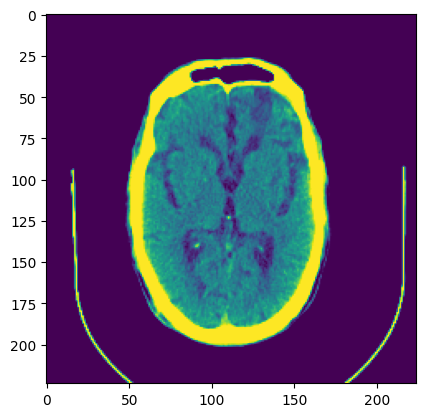

In [52]:
plt.imshow(a[0].numpy())

In [44]:
for i in tqdm(range(len(dataset))):
    a, b = dataset[i]
    if b.sum() > 0:
        break
#     print(a.shape, b.shape)

  0%|          | 0/30572 [00:00<?, ?it/s]

In [53]:
from qtrain.models.train_models import qSegmentation

In [55]:
a, b = next(iter(loader))

In [54]:
model = qSegmentation(args_yaml)

In [56]:
b_ = model(a)

In [62]:
args_yaml.losses

Munch({'dice_ce_loss': DiceCELoss(
  (dice): DiceLoss()
  (cross_entropy): CrossEntropyLoss()
), 'focal_loss': FocalLoss(), 'mse_loss': MSELoss()})

In [66]:
for key in args_yaml.losses:
    print(key, args_yaml.losses[key](b_["masks"], b))

dice_ce_loss tensor(0.9992, dtype=torch.float64, grad_fn=<AddBackward0>)
focal_loss tensor(0.4152, dtype=torch.float64, grad_fn=<MeanBackward0>)
mse_loss tensor(0.3394, dtype=torch.float64, grad_fn=<MseLossBackward0>)


In [22]:
from qtrain.sampler.weighted_sampling import WeightedRandomSampler

In [20]:
dataset = args_yaml.dataset_class(args_yaml)

train data: 100%|███████████████████████████████████████████████████████████████████| 1008/1008 [00:00<00:00, 7239.97it/s]

30572 slices present in train data.



In [24]:
from qtrain.sampler.weighted_sampling import WeightedRandomSampler

s = WeightedRandomSampler(dataset)

In [30]:
loader = DataLoader(
    dataset,
    batch_size=8,
    num_workers=8,
    drop_last=True,
    pin_memory=True,
    shuffle=False,
)

In [31]:
a, b = next(iter(loader))

In [32]:
a.shape, b.shape

(torch.Size([8, 3, 224, 224, 8]), torch.Size([8, 8, 224, 224]))

In [61]:
args.model_params

Munch({'resnet': 'seresnet50', 'attn_mode': 'softminmax'})

In [129]:
model = args.model(**args.model_params).double()

[2023-06-28 09:47:41 +0530] [INFO] Loading pretrained weights from url (https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/seresnet50_ra_224-8efdb4bb.pth)
Total params: 28088024
(8, 224, 224)


In [130]:
out = model(a.reshape(8, 3, 8, 224, 224).double())

In [131]:
out[-1].shape

torch.Size([8, 8, 224, 224])

In [107]:
import torch.nn.functional as F

In [121]:
x = F.softmax(out[-1][1], dim=1)
x = F.interpolate(x, size=(8, 224, 224), mode="trilinear", align_corners=False)
print(x[:, 1].shape)

torch.Size([8, 8, 224, 224])


In [33]:
for i in range(b.shape[0]):
    print(b[i][0].sum())

tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(9)
tensor(308)
tensor(0)
tensor(0)


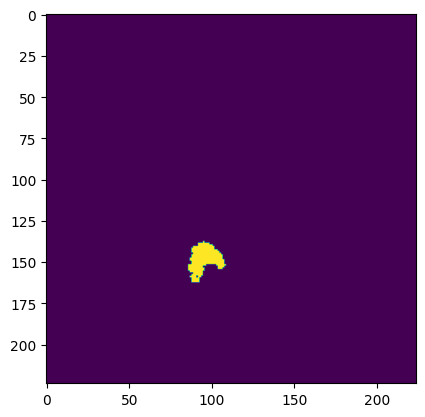

In [45]:
plt.imshow(a[5, 0].numpy())

In [28]:
a, b = dataset[0]
a.shape, b.shap

(torch.Size([3, 224, 224]), torch.Size([1, 224, 224]))

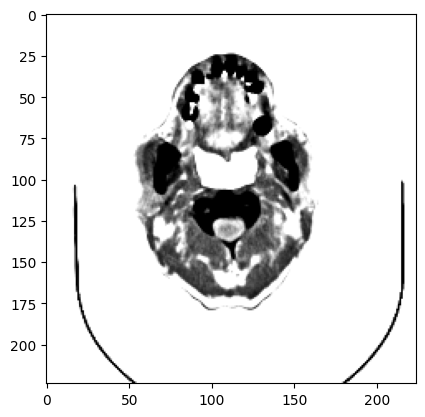

In [37]:
plt.imshow(1 - a[1], cmap="gray")

In [20]:
loader = DataLoader(
    dataset, batch_size=4, num_workers=5, drop_last=True, pin_memory=True, shuffle=True
)

In [21]:
args_yaml.model_params

Munch({'attention_type': 'scse', 'cls_activation': None, 'cls_dropout': '', 'cls_pooling': 'avg', 'decoder_channels': (256, 128, 64, 32, 16), 'depth': 5, 'encoder_name': 'efficientnet-b6', 'in_channels': 3, 'kernel_size': 3, 'n_maps': 1, 'num_classes': 2, 'output_stride': 32, 'seg_activation': None, 'task': ['segmentation'], 'use_batchnorm': True})

In [22]:
args_yaml.model_params

Munch({'attention_type': 'scse', 'cls_activation': None, 'cls_dropout': '', 'cls_pooling': 'avg', 'decoder_channels': (256, 128, 64, 32, 16), 'depth': 5, 'encoder_name': 'efficientnet-b6', 'in_channels': 3, 'kernel_size': 3, 'n_maps': 1, 'num_classes': 2, 'output_stride': 32, 'seg_activation': None, 'task': ['segmentation'], 'use_batchnorm': True})

In [23]:
device = torch.device("cuda:0")
net = args.model(args_yaml).double().to(device)

In [132]:
a, b = next(iter(loader))
a.shape, b.shape

ValueError: Cannot take a larger sample than population when 'replace=False'

In [25]:
b_ = net(a.double().to(device))
b_

{'bottleneck': tensor([[[[ 1.2986e+00,  4.2459e+00,  2.8707e-02,  ..., -2.1694e-02,
            -5.7371e-01,  3.2544e-01],
           [ 4.1972e+00,  1.2084e+00,  2.0003e+00,  ...,  6.2121e+00,
             3.6535e+00,  1.9038e+00],
           [ 6.2838e+00,  5.5532e+00,  5.2816e+00,  ...,  6.0779e+00,
             5.2231e+00,  1.1180e+00],
           ...,
           [ 2.2596e+00,  2.1190e+00,  1.0587e+00,  ..., -1.7133e+00,
            -2.7287e+00, -3.9565e+00],
           [ 1.1604e+00, -5.4772e-01, -1.7022e+00,  ..., -2.9679e+00,
            -3.4359e+00, -2.7978e+00],
           [-4.3790e+00,  1.4270e+00,  5.0571e-01,  ..., -2.7032e+00,
            -3.3087e+00, -5.0852e+00]],
 
          [[ 1.2102e+00,  1.0155e+00,  3.6901e-01,  ..., -1.2052e+00,
             5.3189e-01,  1.6197e+00],
           [ 1.0200e+00,  3.0188e-01,  8.6630e-01,  ..., -7.6782e-01,
             1.6227e+00,  6.0388e-01],
           [ 1.2882e+00, -9.6776e-01,  6.3823e-01,  ..., -1.5994e+00,
             1.0503e+00, 

In [26]:
args_yaml.metrics

Munch({'dice_metric': <monai.metrics.meandice.DiceMetric object at 0x7fb1234f99a0>, 'mse_metric': <monai.metrics.regression.MSEMetric object at 0x7fb1234f99d0>})

In [27]:
str(args_yaml.metrics[0]).split(" ")[0].split(".")[-1]

KeyError: 0

In [ ]:
args_yaml.losses[0](b.double(), b.double())
args_yaml.losses[1](b.double(), b.double())
args_yaml.losses[2](b.double(), b.double())